# House Price

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# reading in data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

### Column names

In [3]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Linear regression on sales price and Lotarea

In [4]:
lotArea = train_data.iloc[:, [0,4]] # this will be our independent variable
salePrice = train_data.iloc[:, [0, -1]] # this will be our dependent variable

In [5]:
# linear regression
regressor = LinearRegression()
regressor.fit(lotArea, salePrice)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

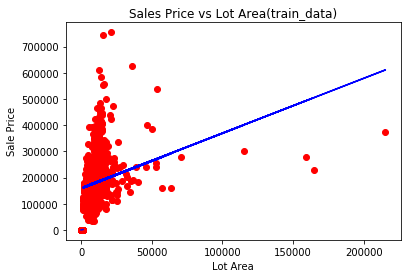

In [6]:
# visualize
plt.scatter(lotArea, salePrice, color='red') # plot all the points
plt.plot(lotArea, regressor.predict(lotArea), color='blue') # plot the regression line
plt.title('Sales Price vs Lot Area(train_data)')
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')
plt.show()

## Year built vs Sales prices

In [11]:
yearBuilt = train_data.iloc[:, [0,19]]
salePrice = train_data.iloc[:, [0, -1]]

In [22]:
# will determine how old house is by currentYear(2017) - yearBuilt
houseAge = []
yearBuiltMatrix = yearBuilt.as_matrix()
for row in range(len(yearBuiltMatrix)):
    houseAge.append([yearBuiltMatrix[row,0], yearBuiltMatrix[row,1]])
    
houseAge